# Vision Transformer

chest data

Ref: https://meditech-ai.com/pytorch-vision-transformer/

In [1]:
!pip install timm

  Using cached safetensors-0.4.5-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 13.0 MB/s eta 0:00:00
Using cached safetensors-0.4.5-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (434 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 26.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.2
    Uninstalling sympy-1.13.2:
      Successfully uninstalled sympy-1.13.2


In [2]:
from __future__ import print_function

import glob
import os
import random
import cv2
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import v2
from tqdm.notebook import tqdm

from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

In [3]:
# Training settings
epochs = 100
lr = 0.001

In [4]:
device = 'cuda'
#device = 'cpu'
train_dataset_dir = Path('./data/Gender01/train')
val_dataset_dir = Path('./data/Gender01/validation')
test_dataset_dir = Path('./data/Gender01/test')

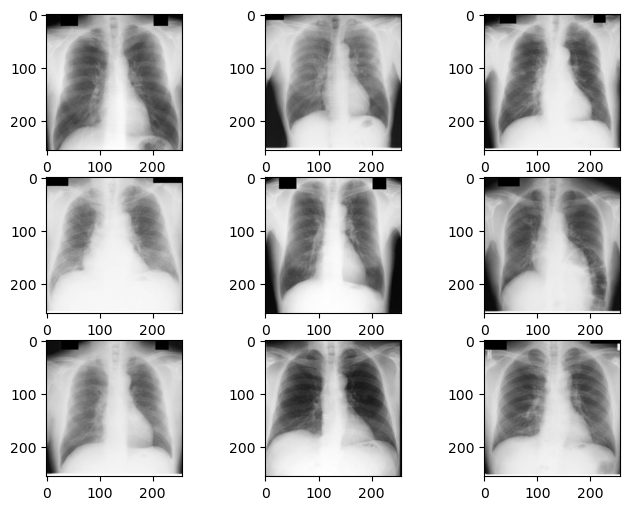

In [5]:
files = glob.glob('./data/Gender01/*/*/*.png')
random_idx = np.random.randint(1, len(files), size=9)
fig, axes = plt.subplots(3, 3, figsize=(8, 6))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(files[idx])
    ax.imshow(img, cmap='gray')

In [6]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [7]:
train_data = datasets.ImageFolder(train_dataset_dir,train_transforms)
valid_data = datasets.ImageFolder(val_dataset_dir, val_transforms)
test_data = datasets.ImageFolder(test_dataset_dir, test_transforms)

In [8]:
train_loader = DataLoader(dataset = train_data, batch_size=16, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=16, shuffle=False)
test_loader = DataLoader(dataset = test_data, batch_size=16, shuffle=False)

In [9]:
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patch16_224.in1k_ft_in1k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k',
 'botnet26t_256.c1_in1k',
 'caformer_b36.sail_in1k',
 'caformer_b36.sail_in1k_384',
 'caformer_b36.sail_in22k',
 'caformer_b36.sail_in22k_ft_in1k',
 'caformer_b36.sail_in22k_ft_in1k_384',
 'caformer_m36.sail_in1k',
 'caformer_m36.sail_in1k_384',
 'caformer_m36.sail_in22k',
 'caformer_m36.sail_in22k_ft_in1k',
 'caformer_m36.sail_in22k_ft_in1k_384',
 'caformer_s18.sail_in1k',
 'caformer_s18.s

In [10]:
model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=2)
model = model.to(device)

/home/kurita/anaconda3/lib/python3.12/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_patch16_224_in21k to current vit_base_patch16_224.augreg_in21k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/410M [00:00<?, ?B/s]

In [12]:
from torchsummary import summary
# print(model)

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
          Identity-5             [-1, 197, 768]               0
          Identity-6             [-1, 197, 768]               0
         LayerNorm-7             [-1, 197, 768]           1,536
            Linear-8            [-1, 197, 2304]       1,771,776
          Identity-9          [-1, 12, 197, 64]               0
         Identity-10          [-1, 12, 197, 64]               0
           Linear-11             [-1, 197, 768]         590,592
          Dropout-12             [-1, 197, 768]               0
        Attention-13             [-1, 197, 768]               0
         Identity-14             [-1, 1

In [13]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [14]:
best_loss = None

# Accuracy計算用の関数
def calculate_accuracy(output, target):
    output = (torch.sigmoid(output) >= 0.5)
    target = (target == 1.0)
    accuracy = torch.true_divide((target == output).sum(dim=0), output.size(0)).item()
    return accuracy

train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)              

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

    train_acc_list.append(epoch_accuracy)
    val_acc_list.append(epoch_val_accuracy)
    train_loss_list.append(epoch_loss)
    val_loss_list.append(epoch_val_loss)

    if (best_loss is None) or (best_loss > val_loss):
        best_loss = val_loss
        model_path = './trained_models/bestViTmodel.pth'
        torch.save(model.state_dict(), model_path)
        
    print()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 1 - loss : 3.4679 - acc: 0.5588 - val_loss : 1.5032 - val_acc: 0.4375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.8823 - acc: 0.5400 - val_loss : 0.7011 - val_acc: 0.5625




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.7113 - acc: 0.5013 - val_loss : 0.9071 - val_acc: 0.4375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.7523 - acc: 0.5575 - val_loss : 0.9473 - val_acc: 0.5625




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.8628 - acc: 0.4975 - val_loss : 0.6972 - val_acc: 0.5625




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.7090 - acc: 0.5913 - val_loss : 0.6744 - val_acc: 0.5625




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.7153 - acc: 0.4887 - val_loss : 1.0593 - val_acc: 0.4375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.8937 - acc: 0.5150 - val_loss : 1.1675 - val_acc: 0.4375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.7177 - acc: 0.5888 - val_loss : 0.8904 - val_acc: 0.4375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6910 - acc: 0.5700 - val_loss : 0.6731 - val_acc: 0.5625




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.7971 - acc: 0.5100 - val_loss : 1.0668 - val_acc: 0.4375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.7766 - acc: 0.5113 - val_loss : 0.7179 - val_acc: 0.4375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.7334 - acc: 0.5225 - val_loss : 0.6980 - val_acc: 0.5625




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.8118 - acc: 0.5013 - val_loss : 0.6573 - val_acc: 0.5625




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.8185 - acc: 0.4938 - val_loss : 0.8406 - val_acc: 0.4375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.6953 - acc: 0.5825 - val_loss : 0.6384 - val_acc: 0.5982




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.6826 - acc: 0.6313 - val_loss : 0.6332 - val_acc: 0.6815




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.6701 - acc: 0.6737 - val_loss : 1.2609 - val_acc: 0.4375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.8488 - acc: 0.4763 - val_loss : 0.8049 - val_acc: 0.4375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.6920 - acc: 0.5475 - val_loss : 0.8740 - val_acc: 0.4375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.6363 - acc: 0.6638 - val_loss : 0.6394 - val_acc: 0.5923




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.6602 - acc: 0.6850 - val_loss : 1.1113 - val_acc: 0.4375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.7455 - acc: 0.5288 - val_loss : 0.7297 - val_acc: 0.4613




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.7436 - acc: 0.5138 - val_loss : 0.8131 - val_acc: 0.5625




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.7358 - acc: 0.5600 - val_loss : 0.6804 - val_acc: 0.5833




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.6019 - acc: 0.6688 - val_loss : 0.6352 - val_acc: 0.6339




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.5800 - acc: 0.7225 - val_loss : 0.8331 - val_acc: 0.5595




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.5404 - acc: 0.7288 - val_loss : 0.5996 - val_acc: 0.7024




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.4766 - acc: 0.8025 - val_loss : 0.8136 - val_acc: 0.6637




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.5051 - acc: 0.7675 - val_loss : 0.8752 - val_acc: 0.6458




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.5561 - acc: 0.7088 - val_loss : 0.7308 - val_acc: 0.6012




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.4946 - acc: 0.7513 - val_loss : 1.2356 - val_acc: 0.5298




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.3710 - acc: 0.8400 - val_loss : 0.8111 - val_acc: 0.5833




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.4300 - acc: 0.8287 - val_loss : 0.6840 - val_acc: 0.6756




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.4146 - acc: 0.8238 - val_loss : 0.8343 - val_acc: 0.6250




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.2997 - acc: 0.9000 - val_loss : 0.6319 - val_acc: 0.6518




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.2331 - acc: 0.9025 - val_loss : 1.0776 - val_acc: 0.6161




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.4081 - acc: 0.8113 - val_loss : 0.5754 - val_acc: 0.6726




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.3188 - acc: 0.8737 - val_loss : 0.6554 - val_acc: 0.7113




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.4130 - acc: 0.8137 - val_loss : 0.7332 - val_acc: 0.6458




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.4133 - acc: 0.7962 - val_loss : 0.7966 - val_acc: 0.6429




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.3551 - acc: 0.8487 - val_loss : 0.6402 - val_acc: 0.6696




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.3436 - acc: 0.8525 - val_loss : 0.9226 - val_acc: 0.6220




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.2755 - acc: 0.8875 - val_loss : 0.7163 - val_acc: 0.7113




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.2623 - acc: 0.8900 - val_loss : 1.3079 - val_acc: 0.5982




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.4602 - acc: 0.7800 - val_loss : 1.2966 - val_acc: 0.5982




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.3484 - acc: 0.8625 - val_loss : 1.0530 - val_acc: 0.6012




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.3036 - acc: 0.9125 - val_loss : 0.5340 - val_acc: 0.7411




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.3377 - acc: 0.8238 - val_loss : 0.5482 - val_acc: 0.7411




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.2667 - acc: 0.8938 - val_loss : 0.7313 - val_acc: 0.6845




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 51 - loss : 0.2986 - acc: 0.8775 - val_loss : 0.5473 - val_acc: 0.8274




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 52 - loss : 0.1711 - acc: 0.9313 - val_loss : 0.8121 - val_acc: 0.7857




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 53 - loss : 0.2016 - acc: 0.9275 - val_loss : 0.7261 - val_acc: 0.7411




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 54 - loss : 0.3078 - acc: 0.8712 - val_loss : 0.7738 - val_acc: 0.7054




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 55 - loss : 0.3378 - acc: 0.8737 - val_loss : 0.7192 - val_acc: 0.7440




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 56 - loss : 0.1970 - acc: 0.9050 - val_loss : 0.6366 - val_acc: 0.7411




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 57 - loss : 0.1530 - acc: 0.9338 - val_loss : 0.9620 - val_acc: 0.6964




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 58 - loss : 0.1536 - acc: 0.9363 - val_loss : 0.9764 - val_acc: 0.7827




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 59 - loss : 0.3867 - acc: 0.8587 - val_loss : 0.6617 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 60 - loss : 0.3483 - acc: 0.8737 - val_loss : 0.6754 - val_acc: 0.7351




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 61 - loss : 0.3837 - acc: 0.8688 - val_loss : 0.7093 - val_acc: 0.6548




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 62 - loss : 0.4697 - acc: 0.7788 - val_loss : 1.0238 - val_acc: 0.5774




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 63 - loss : 0.4294 - acc: 0.7900 - val_loss : 0.5592 - val_acc: 0.7827




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 64 - loss : 0.4329 - acc: 0.8250 - val_loss : 0.6539 - val_acc: 0.6905




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 65 - loss : 0.3791 - acc: 0.8438 - val_loss : 0.7193 - val_acc: 0.6786




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 66 - loss : 0.3590 - acc: 0.8138 - val_loss : 0.7389 - val_acc: 0.6964




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 67 - loss : 0.2875 - acc: 0.8400 - val_loss : 0.7789 - val_acc: 0.7024




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 68 - loss : 0.2691 - acc: 0.9025 - val_loss : 0.6941 - val_acc: 0.7202




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 69 - loss : 0.2045 - acc: 0.9250 - val_loss : 0.8163 - val_acc: 0.7351




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 70 - loss : 0.1296 - acc: 0.9625 - val_loss : 1.2139 - val_acc: 0.6458




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 71 - loss : 0.2816 - acc: 0.8837 - val_loss : 1.4758 - val_acc: 0.5089




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 72 - loss : 0.4826 - acc: 0.7675 - val_loss : 0.6029 - val_acc: 0.7024




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 73 - loss : 0.4716 - acc: 0.7463 - val_loss : 0.7252 - val_acc: 0.6250




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 74 - loss : 0.3494 - acc: 0.8462 - val_loss : 0.6002 - val_acc: 0.7173




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 75 - loss : 0.2517 - acc: 0.9063 - val_loss : 0.7123 - val_acc: 0.7560




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 76 - loss : 0.2119 - acc: 0.9150 - val_loss : 0.7660 - val_acc: 0.7173




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 77 - loss : 0.2525 - acc: 0.9063 - val_loss : 0.6944 - val_acc: 0.7381




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 78 - loss : 0.2194 - acc: 0.9212 - val_loss : 0.6938 - val_acc: 0.7411




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 79 - loss : 0.1817 - acc: 0.9338 - val_loss : 0.7956 - val_acc: 0.7470




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 80 - loss : 0.4297 - acc: 0.8050 - val_loss : 0.4843 - val_acc: 0.6994




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 81 - loss : 0.4133 - acc: 0.7825 - val_loss : 0.5731 - val_acc: 0.7679




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 82 - loss : 0.3791 - acc: 0.7863 - val_loss : 0.6091 - val_acc: 0.7887




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 83 - loss : 0.3015 - acc: 0.8713 - val_loss : 0.5909 - val_acc: 0.8036




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 84 - loss : 0.3114 - acc: 0.8675 - val_loss : 0.6515 - val_acc: 0.7381




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 85 - loss : 0.2486 - acc: 0.9050 - val_loss : 0.5803 - val_acc: 0.8214




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 86 - loss : 0.2157 - acc: 0.8938 - val_loss : 0.6987 - val_acc: 0.7887




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 87 - loss : 0.1363 - acc: 0.9462 - val_loss : 0.7611 - val_acc: 0.8304




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 88 - loss : 0.1783 - acc: 0.9187 - val_loss : 0.7221 - val_acc: 0.7560




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 89 - loss : 0.2766 - acc: 0.8763 - val_loss : 0.5398 - val_acc: 0.8006




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 90 - loss : 0.3100 - acc: 0.9000 - val_loss : 0.6100 - val_acc: 0.7560




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 91 - loss : 0.2901 - acc: 0.8588 - val_loss : 0.5977 - val_acc: 0.7768




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 92 - loss : 0.1595 - acc: 0.9275 - val_loss : 0.8242 - val_acc: 0.7649




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 93 - loss : 0.2132 - acc: 0.9462 - val_loss : 1.0274 - val_acc: 0.7232




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 94 - loss : 0.3180 - acc: 0.8775 - val_loss : 0.8502 - val_acc: 0.7708




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 95 - loss : 0.4386 - acc: 0.8175 - val_loss : 0.4607 - val_acc: 0.7827




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 96 - loss : 0.3750 - acc: 0.7888 - val_loss : 0.4587 - val_acc: 0.7560




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 97 - loss : 0.2977 - acc: 0.8925 - val_loss : 0.5649 - val_acc: 0.7560




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 98 - loss : 0.2197 - acc: 0.9212 - val_loss : 0.5315 - val_acc: 0.7411




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 99 - loss : 0.1657 - acc: 0.9437 - val_loss : 0.6902 - val_acc: 0.8095




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 100 - loss : 0.1833 - acc: 0.9188 - val_loss : 0.6753 - val_acc: 0.8036




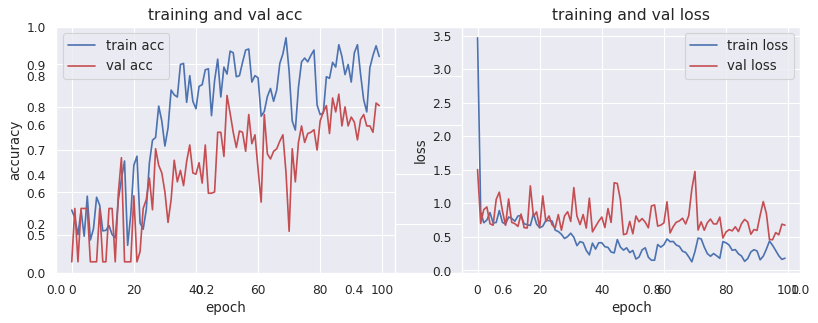

In [15]:
device2 = torch.device('cpu')

train_acc = []
train_loss = []
val_acc = []
val_loss = []

for i in range(epochs):
    train_acc2 = train_acc_list[i].to(device2)
    train_acc3 = train_acc2.clone().numpy()
    train_acc.append(train_acc3)
    
    train_loss2 = train_loss_list[i].to(device2)
    train_loss3 = train_loss2.clone().detach().numpy()
    train_loss.append(train_loss3)
    
    val_acc2 = val_acc_list[i].to(device2)
    val_acc3 = val_acc2.clone().numpy()
    val_acc.append(val_acc3)
    
    val_loss2 = val_loss_list[i].to(device2)
    val_loss3 = val_loss2.clone().numpy()
    val_loss.append(val_loss3)

#取得したデータをグラフ化する
sns.set()
num_epochs = epochs

fig = plt.subplots(figsize=(12, 4), dpi=80)

ax1 = plt.subplot(1,2,1)
ax1.plot(range(num_epochs), train_acc, c='b', label='train acc')
ax1.plot(range(num_epochs), val_acc, c='r', label='val acc')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('accuracy', fontsize='12')
ax1.set_title('training and val acc', fontsize='14')
ax1.legend(fontsize='12')

ax2 = plt.subplot(1,2,2)
ax2.plot(range(num_epochs), train_loss, c='b', label='train loss')
ax2.plot(range(num_epochs), val_loss, c='r', label='val loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('training and val loss', fontsize='14')
ax2.legend(fontsize='12')
plt.show()

/tmp/ipykernel_10242/2837630532.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./trained_models/bestViTmodel.pth"))


Accuracy: 0.5532
感度: 0.8846
特異度: 0.1429
PPV: 0.5610
NPV: 0.5000
F-Score: 0.6866
AUC: 0.6337


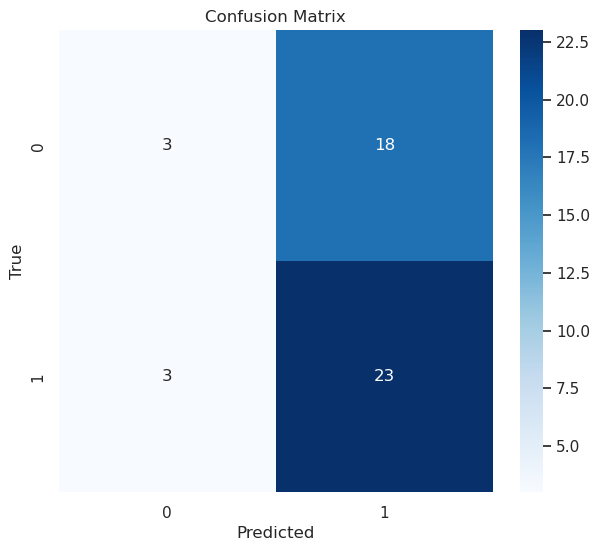

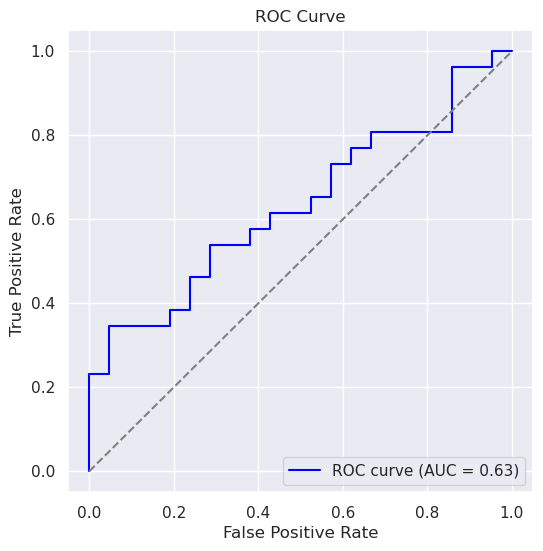

In [16]:
def evaluate_model(model, test_loader):
    model.load_state_dict(torch.load("./trained_models/bestViTmodel.pth"))
    model.eval()
    predictions = []
    actuals = []
    probas = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            probas.extend(outputs[:, 1].cpu().numpy())  # 二番目のクラス（陽性クラス）の確率
            predictions.extend(predicted.cpu().numpy())
            actuals.extend(labels.cpu().numpy())


    # 指標の計算
    confusion = confusion_matrix(actuals, predictions)
    accuracy = accuracy_score(actuals, predictions)
    recall = recall_score(actuals, predictions)  # 感度
    specificity = recall_score(actuals, predictions, pos_label=0)
    precision = precision_score(actuals, predictions)  # PPV
    npv = precision_score(actuals, predictions, pos_label=0)  # NPV
    f1 = f1_score(actuals, predictions)
    auc = roc_auc_score(actuals, probas)


    #print("混同行列:\n", confusion)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"感度: {recall:.4f}")
    print(f"特異度: {specificity:.4f}")
    print(f"PPV: {precision:.4f}")
    print(f"NPV: {npv:.4f}")
    print(f"F-Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")


    # Confusion matrixの描画
    # 混同行列の可視化
    plt.figure(figsize=(7, 6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()


    # ROC曲線の描画
    fpr, tpr, thresholds = roc_curve(actuals, probas)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


evaluate_model(model, test_loader)